In [1]:
# 所有的头

In [32]:
import torch # for save
import os
from van import Fan
from localconfig import config
import datetime
import random
from pprint import pprint
import html
from pyltp import SentenceSplitter
from pyltp import Postagger
from pyltp import Segmentor
from pyltp import NamedEntityRecognizer
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from IPython.core.display import HTML 
import pyecharts
from pyecharts import Pie
from pyecharts import Line
import reverse_geocoder as rg
import requests
from io import BytesIO
%matplotlib inline

plt.rcParams['font.sans-serif']=['FangSong'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


In [3]:
# 所有的配置

In [4]:
keyword = '微信' # 关注的关键词
until_year = 2000 # 最早的年份
until_num = 60000 # 截止的饭否数量
timeout = (60,60) # 超时时间

In [5]:
# 登录
fan = Fan(config['Consumer key'], config['Consumer secret'])
fan.xauth(config['my username'], config['my password'])

{'oauth_token': '1405515-071ad3666b5af9441d5cbb0dc1d3985b',
 'oauth_token_secret': '43cc293f5d127423f960b8636688577b'}

In [6]:
# 本小时内可用API次数
fan.request('GET', 'account/rate_limit_status', {}, timeout=timeout)

{'reset_time': 'Tue Mar 19 00:12:01 +0000 2019',
 'remaining_hits': 150,
 'hourly_limit': 150,
 'reset_time_in_seconds': 1552954321}

In [7]:
# 采集关键词消息
def datetimefromstr(s):
    return datetime.datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
def get_status(keyword, until_year, until_num):
    latest = fan.request('GET', 'search/public_timeline', {'q':keyword, 'count':60}, timeout=timeout)
    
    while True:
        year = datetimefromstr(latest[-1]['created_at']).year
        if len(latest) >= until_num:
            break
        if year < until_year:
            break
        print(len(latest), year,'/', until_num, until_year, end='\r')
        len_ = len(latest)
        latest += fan.request('GET', 'search/public_timeline', { 'q':keyword, 'count':60, 'max_id':latest[-1]['id']}, timeout=timeout)[1:]
        if len(latest) == len_:
            break
    return latest

In [8]:
# 下载并暂存
statuses = get_status(keyword, until_year, until_num)

In [9]:
torch.save(statuses,'tmp_statuses.torch.pkl')

In [10]:
# 恢复
# statuses = torch.load('tmp_statuses.torch.pkl')

In [11]:
print(len(statuses))

60004


In [12]:
# common
def get_top(l, num=5, reverse=False): # 从大到小
    cnt = {}
    for x in l:
        if type(x) == tuple and len(x) == 3:
            x = x[0]
        if x not in cnt:
            cnt[x] = 0
        cnt[x] += 1
    cnt_list = [(k,cnt[k],cnt[k]/len(l)) for k in cnt]
    cnt_list = sorted(cnt_list, key=lambda x:x[1])[::-1]
    if reverse:
        cnt_list = cnt_list[::-1]
    if num == -1:
        return cnt_list
    return cnt_list[:num]
def huabing(y): # x [(label,,0.xxx)]
    attr = [x[0] for x in y]
    v1 = [x[2] for x in y]
    if sum(v1) < 1.0:
        attr.append('其他')
        v1.append(1.0 - sum(v1))
    pie = Pie('')
    pie.add('', attr, v1, is_label_show=True)
    return pie

In [13]:
# 时间段分布

In [14]:
print(datetimefromstr(statuses[-1]['created_at']))
print(datetimefromstr(statuses[0]['created_at']))
begin_year = datetimefromstr(statuses[-1]['created_at']).year
end_year = datetimefromstr(statuses[0]['created_at']).year

2017-04-02 01:43:39+00:00
2019-03-18 23:07:18+00:00


In [15]:
huabing(get_top([datetimefromstr(x['created_at']).year for x in statuses], num = -1))

In [16]:
arr = sorted(get_top([datetimefromstr(x['created_at']).year for x in statuses],num=-1),key = lambda x:x[0])
attr = [str(x[0]) for x in arr ]
v1 = [x[1] for x in arr ]
line = Line('')
line.add(keyword, attr, v1,is_smooth=True,is_label_show=True,mark_line=[ ])
# line.add("商家B", attr, v2, is_smooth=True, mark_line=["max", "average"])
line

In [17]:
# 用户信息文件
os.path.exists('./users.torch.pkl')

True

In [19]:
# 预处理用户信息
userid_to_info = {}
if os.path.exists('./users.torch.pkl'):
    userid_to_info = torch.load('users.torch.pkl')
for x in statuses:
    userid_to_info[x['user']['id']] = x['user']
    if 'repost_status' in x:
        userid_to_info[x['repost_status']['user']['id']] = x['repost_status']['user']
torch.save(userid_to_info, 'users.torch.pkl')
print(len(userid_to_info))

11512


In [20]:
# 发表人数/总消息数量
uni_num = len(set([x['user']['id'] for x in statuses ]))
print(uni_num, len(statuses), uni_num/len(statuses))

7210 60004 0.12015865608959403


In [28]:
def splice_avatar30(urls):
    result_width = 48*6
    result_height = 48*5
    result = Image.new('RGB', (result_width, result_height))
    for i in tqdm(range(5)):
        for j in (range(6)):
            idx = i*6+j
            response = requests.get(urls[idx])
            img = Image.open(BytesIO(response.content))
            result.paste(im=img, box=(j*48, i*48))
    return result
# 5*6

In [29]:
# 发表top30的人
users_top = get_top([x['user']['id'] for x in statuses], num=30)
names_top = [ (userid_to_info[x[0]]['name'] ,  x[1], x[2],x[0]) for x in users_top]
pprint(names_top)
huabing(names_top)

[('糗百', 4307, 0.07177854809679354, 'qiub'),
 ('那.谁', 641, 0.010682621158589428, '海边的暴走族'),
 ('L.1988', 635, 0.01058262782481168, '~q7mHGzyXZro'),
 ('大萌没有Ecup', 532, 0.008866075594960336, 'Emikooo'),
 ('越关山', 457, 0.007616158922738484, '~a8HE2eJqgxU'),
 ('MDJsoftware', 425, 0.007082861142590494, 'mdjsoftware'),
 ('墨滞', 380, 0.006332911139257383, 'subarasii'),
 ('伊丽莎白桑坂田阙日', 363, 0.006049596693553763, 'karl'),
 ('中场休息时闭嘴', 359, 0.005982934471035264, 'jackzhushen'),
 ('万能的饭否', 319, 0.005316312245850277, 'wndff'),
 ('乱耳朵', 286, 0.0047663489100726614, 'Uncle_Luan'),
 ('子浑月阿', 281, 0.004683021131924538, 'emmahathway'),
 ('凡骨', 268, 0.004466368908739417, 'yqwww'),
 ('李时珍的皮', 260, 0.00433304446370242, '闻言文'),
 ('安达充的走狗', 255, 0.004249716685554296, 'wylwddjz'),
 ('胶布啊胶布', 251, 0.0041830544630357975, '胶布同学'),
 ('熊仔饼啊', 229, 0.0038164122391840544, 'chowhong'),
 ('一碗.', 216, 0.0035997600159989335, '~_8nZWTiRSpA'),
 ('Talkaholic_L', 213, 0.0035497633491100595, 'Talkaholic_L'),
 ('马克先森', 210, 0.0034

100%|██████████| 5/5 [00:18<00:00,  3.91s/it]


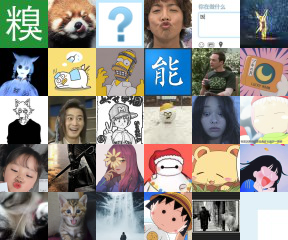

In [33]:
splice_avatar30([userid_to_info[x[0]]['profile_image_url'] for x in users_top])

In [34]:
def show_user_info(x):
    user = userid_to_info[x]
    pprint(user)

In [35]:
show_user_info(users_top[0][0])

{'birthday': '',
 'created_at': 'Wed Feb 17 04:46:39 +0000 2016',
 'description': '糗百非官方机器人，抓取自糗百首页的热门糗事。',
 'favourites_count': 0,
 'followers_count': 6555,
 'following': False,
 'friends_count': 0,
 'gender': '',
 'id': 'qiub',
 'location': '',
 'name': '糗百',
 'notifications': False,
 'photo_count': 143770,
 'profile_background_color': '#acdae5',
 'profile_background_image_url': 'http://static.fanfou.com/img/bg/0.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://s3.meituan.net/v1/mss_3d027b52ec5a4d589e68050845611e68/avatar/s0/00/qa/f6.jpg?1455684943',
 'profile_image_url_large': 'http://s3.meituan.net/v1/mss_3d027b52ec5a4d589e68050845611e68/avatar/l0/00/qa/f6.jpg?1455684943',
 'profile_link_color': '#0066cc',
 'profile_sidebar_border_color': '#b2d1a3',
 'profile_sidebar_fill_color': '#e2f2da',
 'profile_text_color': '#222222',
 'protected': False,
 'screen_name': '糗百',
 'statuses_count': 437053,
 'unique_id': '~vywepXCNPTE',
 'url': 'http://www.qiushibaike.com/',

In [36]:
# 被引用top20的消息

repost_top = get_top([x['repost_status']['id'] for x in statuses if 'repost_status' in x], num=20)
for i in range(len(repost_top)):
    x = repost_top[i]
    for y in statuses:
        if 'repost_status' in y and y['repost_status']['id'] == x[0]:
            repost_top[i] = ('id: '+y['repost_status']['user']['id'] + ' name: '+y['repost_status']['user']['name']  +' '+ html.unescape(y['repost_status']['text']),x[0], x[1],x[2])
            break
            
pprint(repost_top)

[('id: anegie name: 太空小孩 微信的好友上限是 5040 人，这个数字与柏拉图在《法律篇》（The '
  'Laws）中为次级理想国设计的「理想公民人数」是一致的。5040 这个数字的来源是 7 的阶乘，同时柏拉图认为这个数字能被 1~10 以及 12 '
  '整除，可以迎合不同的需求。',
  'tPvdJ_jj47s',
  83,
  0.006636283681138562),
 ('id: karl name: 伊丽莎白桑坂田阙日 从微信取名看性格... 我觉得我是最后一个 微信名字越长 SB几率越高…………………………🙃️',
  'jVjDVOcc-Nc',
  59,
  0.004717358279363556),
 ('id: zenchan name: 布單 '
  '7年前张小龙的两条饭否，如今微信7.0新版本发布，开屏BGM用了Cohen的音乐，Slogan解读了王阳明的文字。',
  'EbTQCYB9vo4',
  55,
  0.0043975373790677225),
 ('id: Olittle name: Olittle '
  '状态不佳，给学生上课使我快乐。转发抽奖，奖品为意大利语初级教程10节，一对一，我教。前100名转发+微信兑奖都算中奖，就是这么任性。有效期至2019年底，不学作废。上课需要提前预约一下，不然我可能在睡觉。上次抽中一个月免费的同学这次就不算了哟。',
  'b82ML9lAsU8',
  51,
  0.004077716478771888),
 ('id: shiziwang name: 王金牙 '
  '今天见识了一个互联网模式，卖小黄文，小伙儿收集各种高质量小黄文，自己审看，做了个微信小程序，每篇可以试读1500字或一章，再想看，微信支付五块钱。想看全部，买会员。我说小黄文自己找着去看呗，谁会买你的，小伙儿女友说，哥，就是有人懒啊，我们就这么个模式，一个月五十万。',
  'cITR987fFFo',
  43,
  0.003438074678180219),
 ('id: ~ga9mK1MYxq4 name: 粉色很好啊但 '
  '我最好的朋友的爸爸出车祸面临截肢，现在她家经济来源全断了，每天要支出几万块的治疗费，她还在读大二，求求大家帮着捐一点或者转一下，求求了，

In [39]:
# 被引用top20的人
repost_user_id_top = get_top([x['repost_status']['user']['id'] for x in statuses if 'repost_status' in x], num=30)
repost_name_top =  [ (userid_to_info[x[0]]['name'] , x[1], x[2],  x[0]) for x in repost_user_id_top]
pprint(repost_name_top)

[('王兴', 325, 0.025985448149036538, 'wangxing'),
 ('东东枪', 267, 0.021348045094746942, 'dongdongqiang'),
 ('越关山', 263, 0.021028224194451106, '~a8HE2eJqgxU'),
 ('糗百', 218, 0.017430239066122972, 'qiub'),
 ('太空小孩', 191, 0.015271447989126089, 'anegie'),
 ('胶布啊胶布', 186, 0.014871671863756297, '胶布同学'),
 ('王金牙', 166, 0.013272567362277124, 'shiziwang'),
 ('伊丽莎白桑坂田阙日', 166, 0.013272567362277124, 'karl'),
 ('大萌没有Ecup', 142, 0.011353641960502118, 'Emikooo'),
 ('子浑月阿', 140, 0.011193731510354202, 'emmahathway'),
 ('毒艹', 114, 0.009114895658431278, 'bisons'),
 ('于大美', 112, 0.008954985208283361, 'dawaiwai'),
 ('粉色很好啊但', 106, 0.00847525385783961, '~ga9mK1MYxq4'),
 ('弥勒儿', 97, 0.007755656832173982, 'xiaoyouzhi'),
 ('即刻精选', 96, 0.007675701607100024, 'jike_bot'),
 ('剑花', 94, 0.007515791156952107, 'dezhaos'),
 ('安达充的走狗', 94, 0.007515791156952107, 'wylwddjz'),
 ('饭友经典语录', 91, 0.007275925481730231, 'fyjdyl'),
 ('阳升', 89, 0.007116015031582314, 'xiaoyangsheng'),
 ('饭而不否', 87, 0.006956104581434397, 'dyxin'),
 ('春燈'

100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


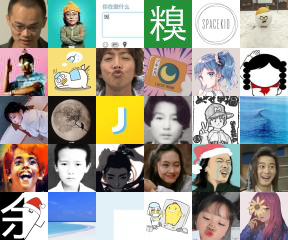

In [40]:
splice_avatar30([userid_to_info[x[0]]['profile_image_url'] for x in repost_user_id_top])

In [41]:
# top20 gender
gender_top = get_top([x['user']['gender'] or '未知' for x in statuses ], num=20)
pprint(gender_top)
huabing(gender_top)

[('未知', 23904, 0.3983734417705486),
 ('男', 20730, 0.34547696820211987),
 ('女', 15370, 0.2561495900273315)]


In [45]:
# converter = {
#     'Jiangsu Sheng' : '江苏',
#     'Shandong Sheng' : '山东',
#     'Shanghai Shi' : '上海',
#     'Beijing' : '北京',
#     'Fujian': '福建',
#     'Guangxi Zhuangzu Zizhiqu': '广西',
#     'Yunnan': '云南',
#     'Tianjin Shi': '天津',
#     'Zhejiang Sheng' : '浙江',
#     'Guangdong': '广东',
#     'Sichuan': '四川',
#     'Hebei': '河北',
#     'TW': '台湾',
#     'Liaoning': '辽宁',
#     'Hunan': '湖南',
#     'Changchun Shi': '长春',
#     'KR' : '韩国',
#     'Henan Sheng': '河南',
#     'Shanxi Sheng': '山西',
#     'Jilin Sheng': '吉林',
#     'Anhui Sheng': '安徽',
#     'Heilongjiang Sheng': '黑龙江',
#     'Jiangxi Sheng': '江西',
#     'ES': '西班牙',
#     'Hubei': '湖北',
#     'SJ' : '斯瓦尔巴群岛和扬马延岛',
#     'Shaanxi': '陕西',
#     'Gansu Sheng': '甘肃',
#     'HK': '香港',
#     'CA' : '加拿大',
#     'Xinjiang Uygur Zizhiqu': '新疆',
#     'JP' : '日本',
#     'Hainan' : '海南',
#     'FR': '法国'
# }
# torch.save(converter, 'geocoverter-en-cn.torch.pkl')

In [43]:
# top20 location

converter = torch.load('geocoverter-en-cn.torch.pkl')
def geotransform(x):
    if len(x) == 0:
        return '未知'
    if ',' in x and len(x.split(',')) == 2:
        try:
            a = x.split(',')
            results = rg.search((float(a[0]),float(a[1]))) # default mode = 2
            if len(results) == 0:
                return '未知'
            if results[0]['cc'] == 'CN':
                if results[0]['admin1'] in converter:
                    return converter[results[0]['admin1']]
                print('\n',len(results[0]['admin1']),results[0],'\n')
                return results[0]['admin1']
            else:
                if results[0]['cc'] in converter:
                    return converter[results[0]['cc']]
                print('\n',len(results[0]['cc']),results[0],'\n')
                return results[0]['cc']
        except Exception as e:
            print(x)
            return '未知'
    if ' ' in x and len(x.split(' ')) == 2:
        return x.split(' ')[0]
    return x
    
location_top = get_top([geotransform(x['location']) for x in tqdm(statuses)], num=20)
pprint(location_top)
huabing(location_top)

  0%|          | 0/60004 [00:00<?, ?it/s]

Loading formatted geocoded file...


 29%|██▊       | 17127/60004 [00:09<00:16, 2675.71it/s]


 2 OrderedDict([('lat', '43.60426'), ('lon', '1.44367'), ('name', 'Toulouse'), ('admin1', 'Midi-Pyrenees'), ('admin2', 'Departement de la Haute-Garonne'), ('cc', 'FR')]) 



 59%|█████▉    | 35328/60004 [00:14<00:09, 2581.88it/s]


 2 OrderedDict([('lat', '13.36179'), ('lon', '103.86056'), ('name', 'Siem Reap'), ('admin1', 'Siem Reap'), ('admin2', ''), ('cc', 'KH')]) 



 68%|██████▊   | 40942/60004 [00:15<00:08, 2264.31it/s]

Rolla, MO


 74%|███████▍  | 44552/60004 [00:17<00:08, 1911.85it/s]


 6 OrderedDict([('lat', '20.00583'), ('lon', '110.35417'), ('name', 'Qiongshan'), ('admin1', 'Hainan'), ('admin2', ''), ('cc', 'CN')]) 



 81%|████████  | 48582/60004 [00:18<00:07, 1502.47it/s]

Rolla, MO


 98%|█████████▊| 59077/60004 [00:24<00:00, 988.20it/s] 


 2 OrderedDict([('lat', '5.26176'), ('lon', '-0.75897'), ('name', 'Mumford'), ('admin1', 'Central'), ('admin2', 'Gomoa West'), ('cc', 'GH')]) 


 2 OrderedDict([('lat', '5.26176'), ('lon', '-0.75897'), ('name', 'Mumford'), ('admin1', 'Central'), ('admin2', 'Gomoa West'), ('cc', 'GH')]) 



100%|██████████| 60004/60004 [00:26<00:00, 2307.49it/s]


 2 OrderedDict([('lat', '5.26176'), ('lon', '-0.75897'), ('name', 'Mumford'), ('admin1', 'Central'), ('admin2', 'Gomoa West'), ('cc', 'GH')]) 

[('未知', 23118, 0.3852743150456636),
 ('北京', 6448, 0.10745950269982),
 ('广东', 4265, 0.0710785947603493),
 ('上海', 3877, 0.06461235917605493),
 ('浙江', 1745, 0.029081394573695088),
 ('海外', 1653, 0.027548163455769617),
 ('江苏', 1484, 0.024731684554363042),
 ('辽宁', 1381, 0.0230151323245117),
 ('湖北', 1174, 0.01956536230917939),
 ('福建', 1031, 0.017182187854143056),
 ('四川', 1011, 0.016848876741550563),
 ('山东', 899, 0.014982334511032598),
 ('黑龙江', 547, 0.009116058929404706),
 ('萌萌星', 532, 0.008866075594960336),
 ('河南', 458, 0.007632824478368109),
 ('天津', 417, 0.006949536697553497),
 ('重庆', 415, 0.0069162055862942474),
 ('陕西', 401, 0.006682887807479501),
 ('湖南', 378, 0.006299580027998133),
 ('湛', 366, 0.006099593360442637)]


In [46]:
def remove_atag(s):
    if '<a' not in s:
        return s
    start = s.find('>')
    end = s.find('</a>',start)
    return s[start+1:end]

In [47]:
# top20 source
source_top = get_top([remove_atag(x['source']) for x in statuses ], num=20)
pprint(source_top)
huabing(source_top)

[('网页', 12101, 0.2016698886740884),
 ('御飯 iOS', 10597, 0.17660489300713286),
 ('猫饭', 8776, 0.14625691620558628),
 ('糗事统计', 4350, 0.0724951669888674),
 ('尚饭', 3268, 0.05446303579761349),
 ('蘑菇饭', 3116, 0.05192987134191054),
 ('Android客户端', 2787, 0.046446903539764016),
 ('有饭', 2139, 0.035647623491767214),
 ('泡饭', 1831, 0.03051463235784281),
 ('「御飯 iPhone」', 1640, 0.027331511232584493),
 ('手机上网', 1604, 0.026731551229918004),
 ('饭团fantuan', 1356, 0.022598493433771082),
 ('Twidere', 1338, 0.022298513432437838),
 ('炒饭', 1205, 0.020081994533697755),
 ('小饭', 881, 0.014682354509699354),
 ('卐能的饭否', 319, 0.005316312245850277),
 ('冷饭', 303, 0.005049663355776282),
 ('PREFiX', 253, 0.004216385574295047),
 ('饭斯基', 215, 0.003583094460369309),
 ('FaWave', 211, 0.00351643223785081)]


In [48]:
# nlp part

In [49]:
def myfilter(s):
    s = s.replace('<strong>','')
    s = s.replace('</strong>','')
    while '转@' in s:
        pos = s.find('转@')
        end = len(s)
        for endsym in [' ', ']', '：',':','@']:
            end2 = s.find(endsym,pos+2)
            if end2 == -1:
                end2 = len(s)
            end = min(end,end2)
        if end-pos > 15:
            print('alert [转@] too long',s)
            s = s[:pos] + s[pos+2:]
        else:
            s = s[:pos] + s[end:]
    while '@' in s:
        pos = s.find('@')
        end = len(s)
        for endsym in [' ', ']', '：',':','@', '\n']:
            end2 = s.find(endsym,pos+1)
            if end2 == -1:
                end2 = len(s)
            end = min(end,end2)
        if end-pos > 15:
            print('alert [@] too long',s)
            s = s[:pos] + s[pos+1:]
        else:
            s = s[:pos] + s[end:]
    if '@' in s:
        print('alert @ in ', s)
    return s

In [50]:
sentences = []
for x in tqdm(statuses):
    s = html.unescape(x['text']) 
    s = myfilter(s)
    if keyword not in s:
        continue
    if '</' in s:
        print(s)
    ss = SentenceSplitter.split(s)
    for t in ss:
        if len(t) > 4:
            sentences.append(t)
    

 13%|█▎        | 7926/60004 [00:00<00:03, 15678.08it/s]

alert [@] too long (1/2) @sein首先这个确实很反人类，强烈抵制，但是他给的地址真的是能打开的，但是只能用微信打开，而且可以开票地址如下：http://fan.fo/XCqu6
点击<a href="https://support.weixin.qq.com/cgi-bin/mmsupport-bin/getopendays?from=groupmessage&amp;isappinstalled=0">这里</a>，看看今天是你和微信同行的第几天？
转
alert [@] too long 决定2019年在社交网络上装个死，朋友圈呀微博呀豆瓣广播呀。所有群里除非工作需要，不@了也可以不出现。本来想直接废了现在的微信账号只用跟家人密友的小号的，但接翻译办签证还是得用到。
alert [@] too long 以前的人有名有字有号，现在大家都只有一个名字了。出国之后即使是同一个实验室的中国人，有的人我只知道他们名字怎么读，具体是哪个字已经不确定了。平常微信里要不就是长按自动@他们的昵称，要不就是直接用拼音。这么想想有点可怕。


 25%|██▍       | 14779/60004 [00:00<00:02, 16550.70it/s]

alert [@] too long 手机匆忙落在办公室拿回来发现小朋友在微信群里@我说有电话，团队智商堪忧啊，后来想想是他帮我接的电话，也dei


 33%|███▎      | 20015/60004 [00:01<00:02, 16871.62it/s]

alert [@] too long 你有Bing啊！   微软的Bing，这个英文单词是一堆的意思，同义尖锐响亮的声音。中文翻译为必应，同音同义，有搜必应也恰如其分。互联网是个信息的储存载体，人对信息的需求还是通过一对多的形式，就如同微信的群里的 或@所有人，等同于饭否上万能的饭否机器人
alert [@] too long   微软的Bing，这个英文单词是一堆的意思，同义尖锐响亮的声音。中文翻译为必应，同音同义，有搜必应也恰如其分。互联网是个信息的储存载体，人对信息的需求还是通过一对多的形式，就如同微信的群里的 或@所有人，等同于饭否上万能的饭否机器人。
alert [@] too long  微软的Bing，这个英文单词是一堆的意思，同义尖锐响亮的声音。中文翻译为必应，同音同义，有搜必应也恰如其分。互联网是个信息的储存载体，人对信息的需求还是通过一对多的形式，就如同微信的群里的 或@所有人，等同于饭否上万能的饭否机器人。
alert [@] too long 过去在NGO  新京报15日采访到原举报人弦子和微博上最早发布人@麦烧同学，两人均希望与朱军对薄公堂，然而报道很快在其网站和微博微信上被删除。16日，另一家媒体“Vista 看天下政商智库”又发布了对当事人的另一篇采访报导。“麦烧同学”在采访中公布了她的本名是徐
alert [@] too long 新京报15日采访到原举报人弦子和微博上最早发布人@麦烧同学，两人均希望与朱军对薄公堂，然而报道很快在其网站和微博微信上被删除。16日，另一家媒体“Vista 看天下政商智库”又发布了对当事人的另一篇采访报导。“麦烧同学”在采访中公布了她的本名是徐超，曾做过环境领域的记者。
alert [@] too long 好的设计有生命力，比如@这个符号，随着微信的普及，这个藏在默认键盘第二屏的符号，大爷大妈都会用了。不知道微信的产品经理当初是如何考虑“提醒”功能的用户教育的
alert [@] too long @介里安安我是直接微信支付就行了


 39%|███▉      | 23288/60004 [00:01<00:02, 14641.50it/s]

alert [@] too long 把批评托班老师的微信语音错发到了老师所在的群。一分钟后校长@被我点名的老师让她限期改正。而我，直到校长@我说他们会继续努力让家长满意并且感谢我的反馈时才发现微信发错了群。希望小宝不会因此受到虐待😂
alert [@] too long 把批评托班老师的微信语音错发到了老师所在的群。一分钟后校长被我点名的老师让她限期改正。而我，直到校长@我说他们会继续努力让家长满意并且感谢我的反馈时才发现微信发错了群。希望小宝不会因此受到虐待😂
alert [@] too long 表姐读初二的儿子早晨叫不醒，上课就瞌睡，被老师在家长微信群@好多次。表姐夫连夜在客厅沙发蹲坑守候，发现这小子趁夜深人静摸黑到客厅打开路由器，趴被窝里玩手游……姐夫埋怨表姐提供作案工具.手机；表姐要斩草除根除恶务尽.断网……爷俩儿这回却是空前绝后的团结，一致反对！
alert [@] too long

 44%|████▍     | 26445/60004 [00:01<00:02, 15147.99it/s]

 @好一棵大白菜不好意思啊，不在上海。可以加微信聊一下。我私信你联系方式。


 50%|████▉     | 29858/60004 [00:01<00:01, 15284.87it/s]

alert [@] too long ……  草泥马，被一个变态同学缠上了，微信、QQ拿各种小号加我，头像都一样，拉黑一个又来一个，在所有的群@我说话，跟所有同学说我跟他怎么怎么
alert [@] too long 春光明媚，带着家人外出踏青再闲适不过，此时若有同事微信@你聊工作，心中万千个草泥马飞过…
alert [@] too long 郭桂山，网名散人。诗人，曾从事写诗、摇滚乐、绘画、行为艺术。从事媒体十余年，国内媒体主编，国际媒体总编。如有约稿访谈等，敬请发函341706254@qq.com或加微信sanren2005。出版专著《被颠覆的汽车帝国》，《风口上的汽车新商业》，《重塑汽车电商未来》。


 55%|█████▍    | 32882/60004 [00:02<00:02, 13518.39it/s]

alert [@] too long 我加了一个肉夹馍外卖群，群主天天@我点餐。群主微信名叫“奋飞的海燕”，我一看到这名字就想起幼时默写并背诵精彩片段的高尔基。
alert [@] too long  我们唧唧喳喳照相馆要招个客户助理，女生，形象佳，亲切开朗，善于沟通，耐心细致者为宜。也欢迎有潜质的应届毕业生。工作地点在北京798，可发简历至：peggy.zhao@gigizhazha.com，或直接加微信peggyzhao0212。请各位帮忙传播下吧，多谢。：））
alert [@] too long  我们唧唧喳喳照相馆要招个客户助理，女生，形象佳，亲切开朗，善于沟通，耐心细致者为宜。也欢迎有潜质的应届毕业生。工作地点在北京798，可发简历至：peggy.zhao@gigizhazha.com，或直接加微信peggyzhao0212。请各位帮忙传播下吧，多谢。：））
alert [@] too long  我们唧唧喳喳照相馆要招个客户助理，女生，形象佳，亲切开朗，善于沟通，耐心细致者为宜。也欢迎有潜质的应届毕业生。工作地点在北京798，可发简历至：peggy.zhao@gigizhazha.com，或直接加微信peggyzhao0212。请各位帮忙传播下吧，多谢。：））
alert [@] too long  我们唧唧喳喳照相馆要招个客户助理，女生，形象佳，亲切开朗，善于沟通，耐心细致者为宜。也欢迎有潜质的应届毕业生。工作地点在北京798，可发简历至：peggy.zhao@gigizhazha.com，或直接加微信peggyzhao0212。请各位帮忙传播下吧，多谢。：））
alert [@] too long 我们唧唧喳喳照相馆要招个客户助理，女生，形象佳，亲切开朗，善于沟通，耐心细致者为宜。也欢迎有潜质的应届毕业生。工作地点在北京798，可发简历至：peggy.zhao@gigizhazha.com，或直接加微信peggyzhao0212。请各位帮忙传播下吧，多谢。：））
alert [@] too long @爽朗君QvQ可以。微信搜美食台，今天放的就是我做的。
alert [@] too long 我这傻逼领导一天早6晚11不间断的在微信群里叮咣的布置工作就够可以了，现在钉钉也用起来了，两边群组不停歇的发各种、每个小时都在发工作内容、你不回他还不行、挨个

 59%|█████▉    | 35617/60004 [00:02<00:01, 12343.95it/s]

alert [@] too long http://fan.fo/WmwJc 转的，部门聚会，大家玩起大冒险。要求输的一方，给微信上排序为25的好友，发一句“睡了吗？” 轮到小町的时候，她果断说：换一个吧，这个不行。 大家一看，觉得有故事，便故意起哄，非这#@个人不可。小町看糊弄不过去，只好坦白交代，那个人是她前任。
alert [@] too long 从上周开始，每周一要提前一小时来公司开会，到这 HR 微信语言打给我们打电话问我们到没到，等人到齐后 HR 在公司群@所有人晚到或缺席要提前请假。按着步步紧逼的节奏，下周开会估计要打卡记考勤了。
alert [@] too long 从上周开始，每周一要提前一小时来公司开会，到这 HR 微信语言打给我们打电话问我们到没到，等人到齐后 HR 在公司群@所有人晚到或缺席要提前请假。按着步步紧逼的节奏，下周开会估计要打卡记考勤了。


 66%|██████▌   | 39591/60004 [00:02<00:01, 11156.06it/s]

alert [@] too long   ‪RT @try2feel（twitter） 微信官方声称，微信不留存用户聊天记录。好吧，不做技术解读，发张图应该直观点。‬
alert [@] too long 。。。。下班之前还@企业微信让开发个电脑关机打卡功能，结果上了地铁才想起来打卡。
alert [@] too long 真的好烦那种自己只是被抄送在邮件里，却被正文某个角落@到然后被安排的任务。日妈你们要派活不能稍微弄得正式一点点吗，还是天真以为@一下名字就能警铃大作？更过分的是同样的人，有时候还在微信群里分派任务，这时候又不记得@人名了，谁他妈有功夫盯着聊天记录看自己有没有被提到啊？
alert [@] too long 真的好烦那种自己只是被抄送在邮件里，却被正文某个角落到然后被安排的任务。日妈你们要派活不能稍微弄得正式一点点吗，还是天真以为@一下名字就能警铃大作？更过分的是同样的人，有时候还在微信群里分派任务，这时候又不记得@人名了，谁他妈有功夫盯着聊天记录看自己有没有被提到啊？
alert [@] too long 真的好烦那种自己只是被抄送在邮件里，却被正文某个角落到然后被安排的任务。日妈你们要派活不能稍微弄得正式一点点吗，还是天真以为一下名字就能警铃大作？更过分的是同样的人，有时候还在微信群里分派任务，这时候又不记得@人名了，谁他妈有功夫盯着聊天记录看自己有没有被提到啊？
alert [@] too long ‪RT @try2feel（twitter） 微信官方声称，微信不留存用户聊天记录。好吧，不做技术解读，发张图应该直观点。‬
alert [@] too long 来自 TualatriX（@tualatrix）的推文，写于 2017年12月31日 上午10:03 - 原来微信的「跳一跳」是学这款 Bottle Flip 的： https://t.co/DRKmRKNRuE https://t.co/QXy65VgnpU
alert [@] too long 2017年9月：微博博主@奶騎本騎發了一條內容為「『佛系追星』」一剛，受教了，阿彌陀佛善哉善哉」的博文
2017年11月21日，微信公號「留通社」：《胃垮了，頭禿了，離婚了，90後又開始追求佛系生活了？》「佛系」一詞終於脫離垂直圈子（社交），開始進入大眾視野。
alert [@] too l

 71%|███████   | 42725/60004 [00:02<00:01, 13065.46it/s]

alert [@] too long 微信群@人，感觉和饭否隔空对话是一样的
alert [@] too long 盯着一个鸡窝的好烦。 主任刚刚群里发微信，特意@我，叫我明天发型弄弄好，明天科里拍宣传片……妈个鸡！我的天天很乱吗？
alert [@] too long 嗯……我不婚不育的决定还是很对的…… 😂

RT ‪@Orzzai（twitter） 朋友在产房里上接不接下气的给我们发微信劝大家结婚前想清楚因为‬

‪“产房里所有需要签字的东西 只能配偶来签 妈都不行”‬


 78%|███████▊  | 46800/60004 [00:03<00:01, 11404.94it/s]

alert [@] too long http://t.cn/RO0Kec4 我是因为她才玩的糗百，@程。。昨晚梦见你跟别人结婚啦，自己在梦里特别后悔，分手一年多啦，我这个人渣提出的，早上醒啦以后打电话不接，微信QQ删啦，联系不上，一年前已经把我拉黑啦，我承认我是个人渣，但是我现在只想跟她结婚，我愿意付出我的所有，只
alert [@] too long 我去，在高铁站找不到地铁口像问一个年轻工作人员问路，年轻小哥说：“往南边走，嘿感觉你好眼熟，你在哪个学校毕业的，会不会是校友”我说不会吧，小哥用超小的声音说#@％*微信*％~?，什么？我听不清楚，他说“可以加你的微信号吗”哈哈哈，套路啊，我今天明明很挫的啊。
alert [@] too long  「 🍚  成为了分发者，有 15 个体验权限。想体验小饭请发微信号给 @猫弟，或参考教程自己搭建。教程地址：http://www.billlee.win/archives/139」
alert [@] too long 「 🍚  成为了分发者，有 15 个体验权限。想体验小饭请发微信号给 @猫弟，或参考教程自己搭建。教程地址：http://www.billlee.win/archives/139」
alert [@] too long 哭泣 我看不懂…… 🍚  成为了分发者，有 15 个体验权限。想体验小饭请发微信号给 @猫弟，或参考教程自己搭建。教程地址：http://www.billlee.win/archives/139
alert [@] too long 啊，是发微信号吗？微信号：Freihow，求体验。   🍚  成为了分发者，有 15 个体验权限。想体验小饭请发微信号给 @猫弟，或参考教程自己搭建。教程地址：http://www.billlee.win/archives/139
alert [@] too long 「  🍚  成为了分发者，有 15 个体验权限。想体验小饭请发微信号给 @猫弟，或参考教程自己搭建。教程地址：http://www.billlee.win/archives/139」
alert [@] too long   🍚  成为了分发者，有 15 个体验权限。想体验小饭请发微信号给 @猫弟，或参考教程自己搭建。教程地址：http://www.billlee.win/archives/13

 82%|████████▏ | 49501/60004 [00:03<00:00, 12363.05it/s]

alert [@] too long 刚才睡了个回笼觉，梦到我刷饭看到5个@，居然有两条是阿呆，他发现我的饭否账号了！头像就是微信的，转发了一两条写着？吓得我赶紧找小锁，还没找到，于是醒了。所以我要不要加上锁啊……
alert [@] too long 一个晚上写了十个笑话了，还是想吐槽下我朋友，你七夕节结婚！娶了白富美！妈的还@我！我告诉你，我微信随个份子给你，就是不去看你们秀恩爱！哼，气死你！
alert [@] too long 最近做的很机智的事情，把所有纹眉脱毛介绍对象的微博推广账号见一个点一个加入黑名单，感觉刷微博好多了；把好几十个微信服务号的推送耐心的一个个关闭推送（因为工作不能删，偶尔还是要去看），感觉微信清净了好多；公司自己电脑的wifi名改成@AAAAAA，轻松排列成全司第一个Wifi。


 92%|█████████▏| 55234/60004 [00:04<00:00, 12645.26it/s]

alert [@] too long 刚出门，被领导在微信群里@，说什么江湖救急，让我临时这个文案。以最快的速度写完了，打电话给领导确认，结果挂了电话半个小时过去了，群里没任何反应……我就被这么干耗着！
alert [@] too long 微信群的群@提醒功能还是做得太失败了，刚打开几个学校的班级群和通知群看了下，还有不少群主认为自己发“@所有人”对群提醒有效。


100%|██████████| 60004/60004 [00:04<00:00, 12869.82it/s]

alert [@] too long 好的，在妙哉市集的微信公众号上下单了Absolute Fanfou by@田耐里，我真是慢别人好多拍#T恤#
alert [@] too long 红旗渠征文启示  稿件投递：请登录征文官网http://www.hongqiquzw.cn，在投稿专区进行投递，或发邮件至zsw088809@163.com，并关注微信号hongqiquzw（红旗渠精神永放光芒）如有其他疑问，请登录征文官网查询联系方式：18210058853
alert [@] too long   红旗渠征文启示
  稿件投递：请登录征文官网http://www.hongqiquzw.cn，在投稿专区进行投递，或发邮件至zsw088809@163.com并关注微信号hongqiquzw（红旗渠精神永放光芒,如有其他疑问,请登录征文官网查询,联系方式：1821
alert [@] too long 红旗渠征文启示
  稿件投递：请登录征文官网http://www.hongqiquzw.cn，在投稿专区进行投递，或发邮件至zsw088809@163.com并关注微信号hongqiquzw（红旗渠精神永放光芒,如有其他疑问,请登录征文官网查询,联系方式：18210058853


In [51]:
print(len(sentences))

128379


In [52]:
# 对sentences去重。。 拒绝转发的影响 （存疑？）
# 不去重

In [53]:
# sentences = list(set(sentences))

In [54]:
print(len(list(set(sentences))))

103834


In [55]:
get_top(sentences,num=20)

[('524页。', 95, 0.0007399964168594552),
 ('用了七支半笔。', 92, 0.0007166281089586303),
 ('以后都不会做这傻事了。', 88, 0.0006854703650908638),
 ('把一个人的微信聊天记录抄了下来。', 82, 0.000638733749289214),
 ('5040 这个数字的来源是 7 的阶乘，同时柏拉图认为这个数字能被 1~10 以及 12 整除，可以迎合不同的需求。',
  65,
  0.0005063133378512062),
 ('微信的好友上限是 5040 人，这个数字与柏拉图在《法律篇》（The Laws）中为次级理想国设计的「理想公民人数」是一致的。',
  55,
  0.00042841897818178987),
 ('前100名转发+微信兑奖都算中奖，就是这么任性。', 52, 0.00040505067028096496),
 ('转发抽奖，奖品为意大利语初级教程10节，一对一，我教。', 52, 0.00040505067028096496),
 ('有效期至2019年底，不学作废。', 48, 0.0003738929264131984),
 ('出来的结果按照条数顺序依次往下就是奸情的浓稠程度。', 45, 0.00035052461851237354),
 ('一万次的屡试不爽。', 44, 0.0003427351825454319),
 ('新年，愿山海相逢，明朗可期，逝者不被消费，新生获得珍惜，你我聪慧独立，对流量微信，对压力陌陌，日子免于强咚，上马总有青云。',
  42,
  0.00032715631061154863),
 ('他学渣一个没办法，只好南下去腾讯（深圳本部还不要，只好去广州）搞莫名其妙的微信。', 40, 0.0003115774386776654),
 ('微信居然有窜消息这种致命bug！', 39, 0.0003037880027107237),
 ('7年前张小龙的两条饭否，如今微信7.0新版本发布，开屏BGM用了Cohen的音乐，Slogan解读了王阳明的文字。',
  39,
  0.0003037880027107237),
 ('想看全部，买会员。', 38, 0.00029599856674

In [56]:
# torch.save(['尼玛', '卧槽', '傻逼', '对了', '有木有', '他妈'],'blacklist.torch.pkl' )
def add_to_blacklist(w):
    global blacklist
    blacklist = torch.load('blacklist.torch.pkl')
    blacklist.append(w)
    torch.save(blacklist,'blacklist.torch.pkl')

In [57]:
# 无意义
blacklist = torch.load('blacklist.torch.pkl')

In [58]:
words_all = []

segmentor = Segmentor()
postagger = Postagger()
recognizer = NamedEntityRecognizer()
postagger.load('./ltp_data_v3.4.0/pos.model')
segmentor.load('./ltp_data_v3.4.0/cws.model')
recognizer.load('./ltp_data_v3.4.0/ner.model')

#todo 情感分析

for s in tqdm(sentences):
    words = segmentor.segment(s)
    postags = postagger.postag(words) #词性标注
    netags = recognizer.recognize(words, postags) # 命名实体识别
    for i in range(len(words)):
        if words[i] in blacklist:
            continue
        words_all.append((words[i],postags[i],netags[i]))

segmentor.release()
postagger.release()
recognizer.release()

100%|██████████| 128379/128379 [04:15<00:00, 502.39it/s]


In [59]:
print(len(words_all))

2532934


In [ ]:
get_top([x[0] for x in words_all if len(x[0])>1 and x[1]!='wp'], num = 25)

In [ ]:
posdict = {}
nedict = {}
for x in tqdm(words_all):
    if x[1] not in posdict:
        posdict[x[1]] = []
    if x[2] not in nedict:
        nedict[x[2]] = []
    posdict[x[1]].append(x)
    nedict[x[2]].append(x)

In [ ]:
All_interested_words = []
All_interested_words += posdict['i']
All_interested_words += posdict['j']
All_interested_words += posdict['n']
All_interested_words += [x for x in posdict['ws'] if len(x[0])>=4 and not x[0].startswith('http://')]
All_interested_words += posdict['nh']+ nedict['S-Nh']
All_interested_words += posdict['ni']+posdict['nz']+nedict['S-Ns']

In [ ]:
inte_top = get_top(All_interested_words, num = 40)

pprint(inte_top)
huabing(inte_top)
','.join([x[0] for x in inte_top])

In [ ]:
# 人名

# ['nh'] 人名词
people_top = get_top(posdict['nh']+ nedict['S-Nh'], num=25)
pprint(people_top)
huabing(people_top)

In [ ]:
# 组织名

# ['ni'] 组织名
group_top = get_top(posdict['ni']+posdict['nz']+nedict['S-Ns'], num=5)
pprint(group_top)
huabing(group_top)


In [ ]:
# 词性
print(posdict.keys())


In [ ]:
# ['i'] 成语
pprint(get_top(posdict['i'], num=25))

In [ ]:

# ['j'] 缩略词
pprint(get_top(posdict['j'], num=25))


In [ ]:

# ['n'] 名词
pprint(get_top(posdict['n'], num=25))


In [ ]:

# ['nh'] 人名词
pprint(get_top(posdict['nh'], num=25))


In [ ]:

# ['ni'] 组织名
pprint(get_top(posdict['ni'], num=25))


In [ ]:

# ['nz'] other proper name
pprint(get_top(posdict['nz'], num=25))


In [ ]:

# ['v'] verb len >= 2
# pprint(get_top([x for x in posdict['v'] if len(x[0])>=2], num=25))


In [ ]:

# foreign words	
pprint(get_top([x for x in posdict['ws'] if len(x[0])>=4 and not x[0].startswith('http://')], num=25))


In [ ]:
# 命名实体
print(nedict.keys())


In [ ]:


# 人名
pprint(get_top(nedict['S-Nh'], num=25))


In [ ]:

# 机构名
pprint(get_top(nedict['S-Ni'], num=25))


In [ ]:

# 地名
pprint(get_top(nedict['S-Ns'], num=25))

In [ ]:
# 以上内容均为自动生成...